#Stacked Regressions to predict House Prices 


##Serigne

**July 2017**

**If you use parts of this notebook in your scripts/notebooks, giving  some kind of credit would be very much appreciated :)  You can for instance link back to this notebook. Thanks!**

This competition is very important to me as  it helped me to begin my journey on Kaggle few months ago. I've read  some great notebooks here. To name a few:

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  : Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  : Thorough features engeneering and deep dive into linear regression analysis  but really easy to follow for beginners.

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation

I can't recommend enough every beginner to go carefully through these kernels (and of course through many others great kernels) and get their first insights in data science and kaggle competitions.

After that (and some basic pratices) you should be more confident to go through [this great script][7] by **Human Analog**  who did an impressive work on features engeneering. 

As the dataset is particularly handy, I  decided few days ago to get back in this competition and apply things I learnt so far, especially stacking models. For that purpose, we build two stacking classes  ( the simplest approach and a less simple one). 

As these classes are written for general purpose, you can easily adapt them and/or extend them for your regression problems. 
The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

To my surprise, this does well on LB ( 0.11420 and top 4% the last time I tested it : **July 2, 2017** )



**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
# print(os.listdir("../input/kernel-files"))

In [2]:
# Read in the dataset as a dataframe
train =pd.read_csv("/Users/yankesswang/Downloads/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/Users/yankesswang/Downloads/house-prices-advanced-regression-techniques/test.csv")
train.shape, test.shape


((1460, 81), (1459, 80))

In [3]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
##display the first five rows of the test dataset.
test.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


#Data Processing

## 目標變數

#SalePrice:我們需要預測的變量。所以讓我們先對這個變量進行一些分析。

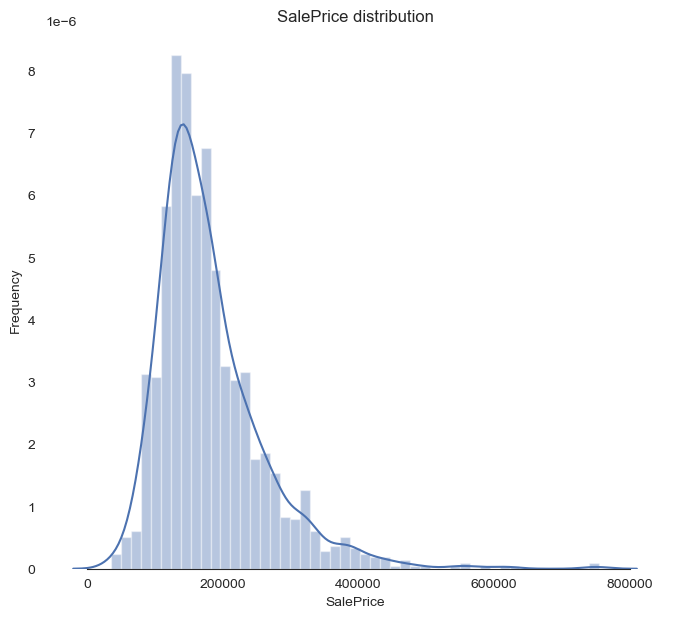

In [6]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()


 mu = 180921.20 and sigma = 79415.29



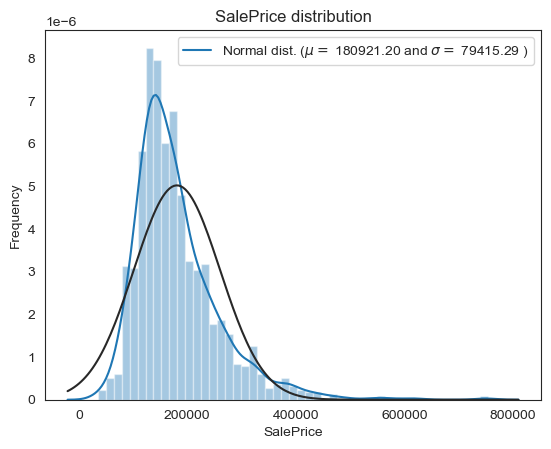

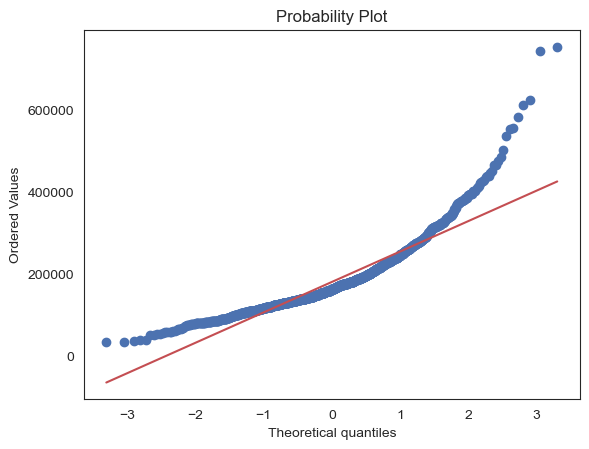

In [7]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

目標變量是右偏的。由於（線性）模型喜歡正態分佈的數據，我們需要轉換這個變量，使其更接近正態分佈。

In [8]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## 經對數轉換後資料，解決偏態

 **Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



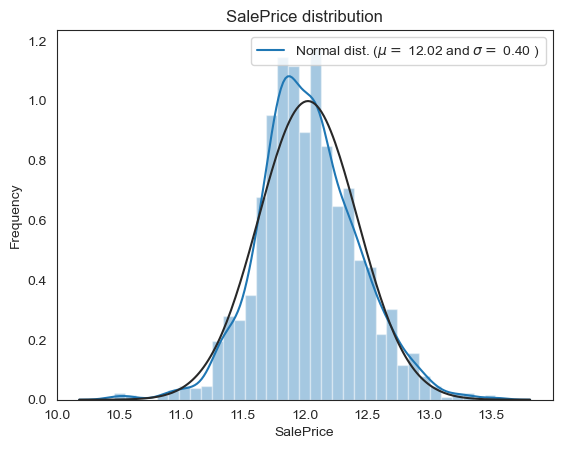

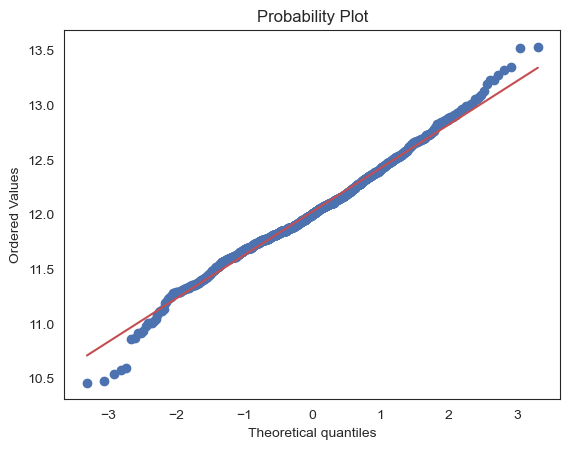

In [9]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


偏斜現在似乎已經被糾正，而數據似乎更接近正態分佈。

In [10]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


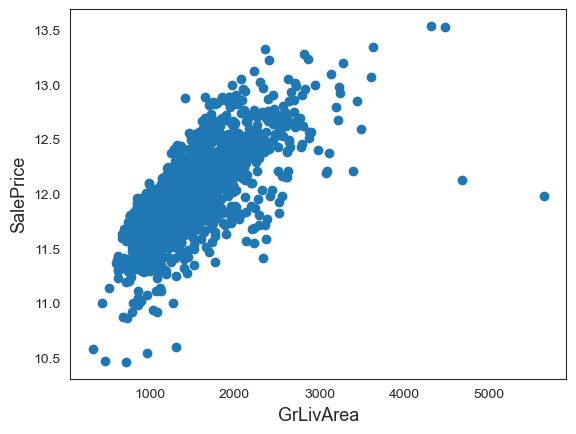

In [11]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


我們可以看到右下角有兩個具有極大的 GrLivArea 但價格卻很低的數值。這些數值是巨大的異常值。因此，我們可以放心地刪除它們。

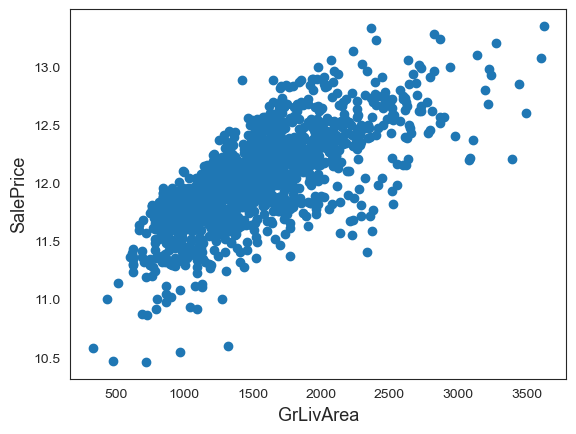

In [12]:
#刪除離群值
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#再檢查圖表一遍
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

###Note : 
刪除異常值並不總是安全的。我們決定刪除這兩個數值，因為它們非常巨大且真的很不好（非常大的面積但價格卻非常低）。

訓練數據中可能還有其他的異常值。但是，如果測試數據中也存在異常值，則刪除所有這些值可能會對我們的模型產生不良影響。這就是為什麼我們不選擇刪除所有異常值，而是選擇使我們的部分模型對它們更加魯棒。

## 特徵工程 Features engineering

將訓練數據和測試數據合併到同一個數據框中

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 79)


## 缺失值 Missing Data

In [14]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageFinish,5.454545
GarageQual,5.454545
GarageCond,5.454545
GarageYrBlt,5.454545


Text(0.5, 1.0, 'Percent missing data by feature')

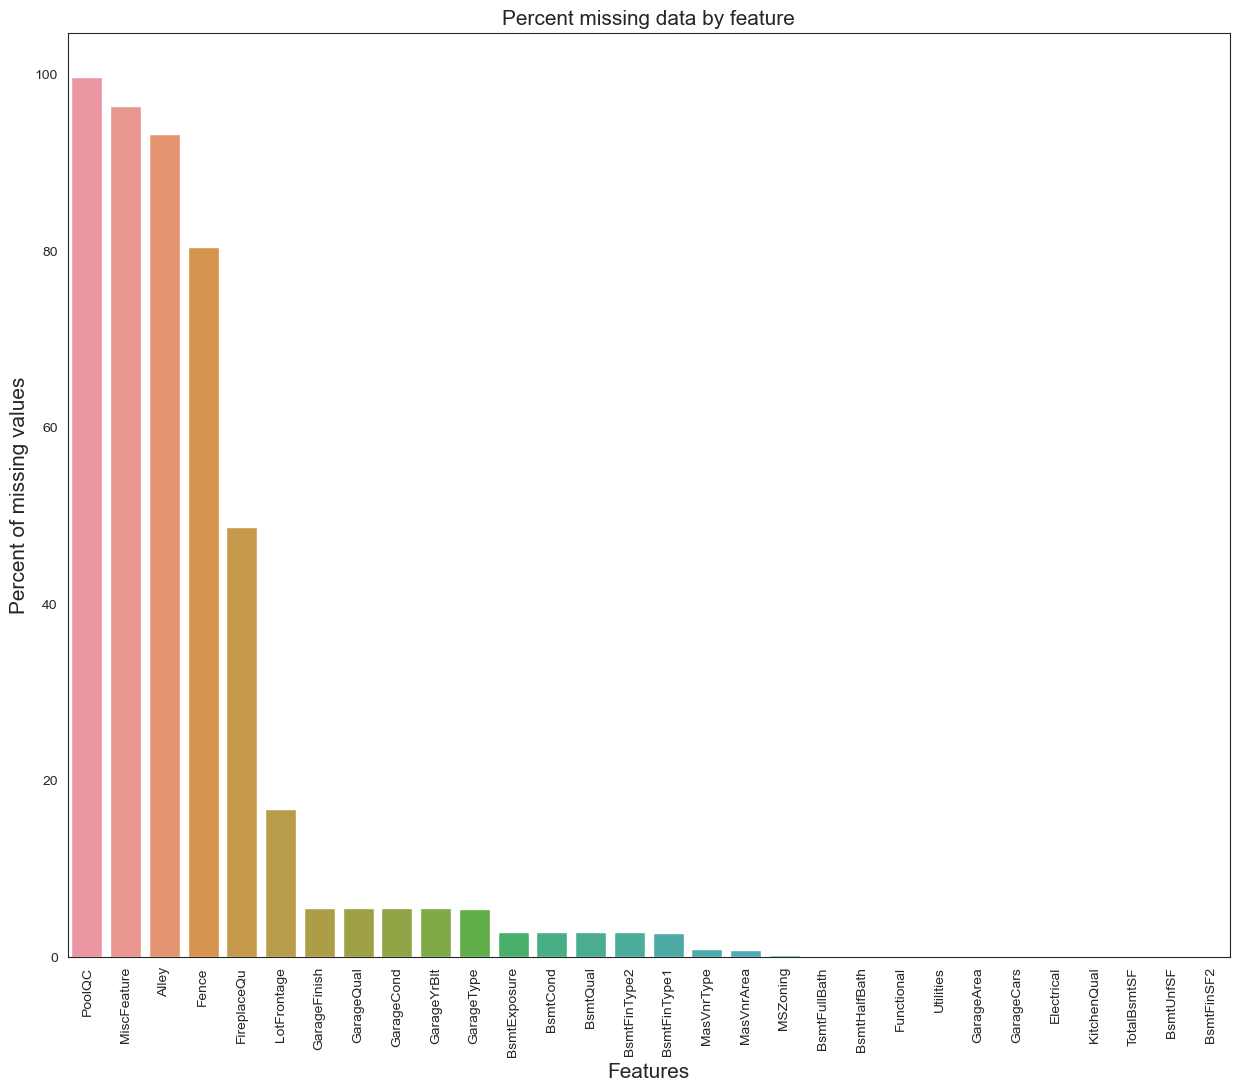

In [15]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

缺失值比例由高到低

**相關係數：Correlation**


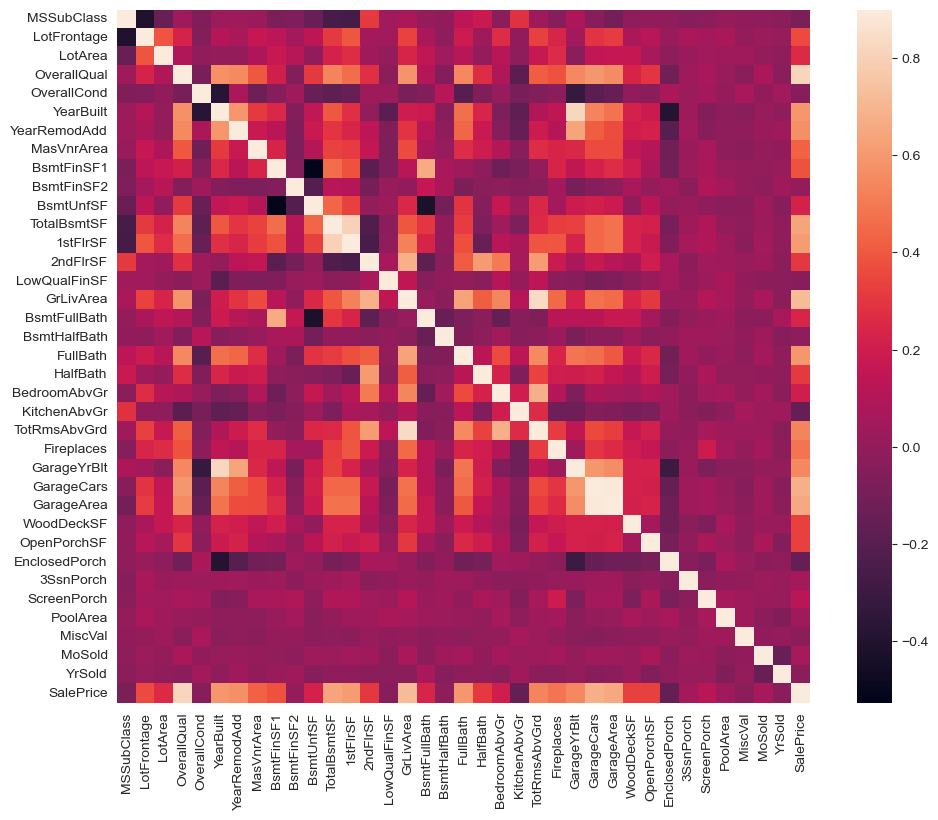

In [16]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

## 處理缺失值 

## 1.用NA補值

- **PoolQC**: 資料描述指出 NA 意味著 "沒有泳池"。考慮到缺失值的巨大比例（超過99%）以及一般上大多數的房屋都沒有泳池，這是有道理的。

In [17]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

## 2.用中位數補值

- **LotFrontage：由於每條與房屋土地相連的街道的面積很可能與其鄰近的其他房屋有相似的面積，我們可以使用該鄰近地區的LotFrontage中位數來填充缺失值。

In [22]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [24]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

## 3.用眾數補值(最常出現的數字)

- **MSZoning (一般分區分類)：'RL' 明顯是最常見的值。因此，我們可以用 'RL' 來填充缺失的值。


In [28]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


## 4.刪除值dropna fillna

In [29]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [30]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

## 檢查是否還有缺失值

In [36]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.


## 特徵轉換

**將一些真正屬於類別型的數值變量進行轉換**

In [37]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Label Encoding： 對某些可能在其排序集中包含信息的類別變量進行標籤編碼。** 

In [38]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2915, 78)


## 新增特徵

In [39]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Skewed features**

In [40]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
LandSlope,4.971350
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [41]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [42]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2915, 220)


Getting the new train and test sets. 

In [43]:
train = all_data[:ntrain]
test = all_data[ntrain:]


## 建造模型

**Import librairies**

** 定義cross validation strategy**

我們使用 Sklearn 的 cross_val_score 函數。然而，這個函數沒有洗牌屬性，所以我們加了一行代碼，以便在交叉驗證之前對資料集進行洗牌。

In [45]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 基本模型

-  **LASSO  Regression**  : 

我們使用 Sklearn 的 cross_val_score 函數。然而，這個函數沒有洗牌屬性，所以我們加了一行代碼，以便在交叉驗證之前對資料集進行洗牌。

In [107]:
from sklearn.model_selection import \
    KFold, RepeatedKFold, GridSearchCV, \
    cross_validate, train_test_split
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0, 0.2, 21)
lasso = Lasso()
grid = dict()
grid['alpha'] = lasso_alphas
gscv = GridSearchCV(
    lasso, grid, scoring=rmsle_cv,
    cv=cv, n_jobs=1  # No parallelism
)

results = gscv.fit(train, y_train)
print('MAE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: nan
Config: {'alpha': 0.0}


In [46]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

In [47]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [48]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [49]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [77]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial, X=train, y=y_train):
    """
    A function to train a model using different hyperparamerters combinations provided by Optuna.
    """
    X_train, X_valid, y_traing, y_valid = train_test_split(train, y_train, test_size=0.4)

    params = {
        "silent": 1,
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500, 100),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "nthread" : -1,
        'random_state' :7
    }
    # model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

    reg = xgb.XGBRegressor(**params)
    reg.fit(X_train, y_traing,
            eval_set=[(X_valid, y_valid)], eval_metric='rmse',
            verbose=False)
    return mean_squared_error(y_valid, reg.predict(X_valid), squared=False)

In [79]:
%%time
# Creating Optuna object and defining its parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 30)

# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2023-09-23 20:04:29,991] A new study created in memory with name: no-name-612e3765-15cc-46b0-8d31-3e915a34dca9


[20:04:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:04:31,632] Trial 0 finished with value: 0.16969660586151833 and parameters: {'booster': 'gbtree', 'max_depth': 7, 'subsample': 0.4487484959837789, 'n_estimators': 600, 'eta': 0.007574602521343894, 'alpha': 7.871919611648184e-06, 'lambda': 6.835614846537971e-07, 'gamma': 2.786326310977875e-06, 'min_child_weight': 4.589879418295014, 'grow_policy': 'depthwise', 'colsample_bytree': 0.6157872704616447}. Best is trial 0 with value: 0.16969660586151833.


[20:04:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:04:38,251] Trial 1 finished with value: 11.113046146442386 and parameters: {'booster': 'gbtree', 'max_depth': 8, 'subsample': 0.599885323478788, 'n_estimators': 1800, 'eta': 2.0976288933442076e-05, 'alpha': 0.004028569971680378, 'lambda': 0.00019497890187982622, 'gamma': 0.00032187631666578004, 'min_child_weight': 1.2096268253575384, 'grow_policy': 'depthwise', 'colsample_bytree': 0.9327722246898589}. Best is trial 0 with value: 0.16969660586151833.


[20:04:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:16:47,172] Trial 2 finished with value: 11.525384082082343 and parameters: {'booster': 'dart', 'max_depth': 8, 'subsample': 0.8535748205142739, 'n_estimators': 2100, 'eta': 2.963285688864651e-07, 'alpha': 8.955951120129304e-07, 'lambda': 1.6828581218381378e-07, 'gamma': 5.838738848436405e-07, 'min_child_weight': 1.7381254597848628, 'grow_policy': 'lossguide', 'colsample_bytree': 0.7679522271642567}. Best is trial 0 with value: 0.16969660586151833.


[20:16:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:16:48,200] Trial 3 finished with value: 11.521898007401282 and parameters: {'booster': 'gbtree', 'max_depth': 8, 'subsample': 0.4111918065973072, 'n_estimators': 600, 'eta': 2.991917541735283e-07, 'alpha': 0.05401050357303714, 'lambda': 0.004226954183758107, 'gamma': 1.6365682195602722e-05, 'min_child_weight': 6.803469233870787, 'grow_policy': 'depthwise', 'colsample_bytree': 0.6093592827107077}. Best is trial 0 with value: 0.16969660586151833.


[20:16:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:16:51,610] Trial 4 finished with value: 11.530353975646245 and parameters: {'booster': 'gbtree', 'max_depth': 3, 'subsample': 0.6975034844282575, 'n_estimators': 1900, 'eta': 1.8425530890186564e-07, 'alpha': 0.0417971721926932, 'lambda': 9.839788282229635e-05, 'gamma': 2.3554625413792338e-08, 'min_child_weight': 2.9655670499729467, 'grow_policy': 'lossguide', 'colsample_bytree': 0.5971786413342832}. Best is trial 0 with value: 0.16969660586151833.


[20:16:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:16:53,839] Trial 5 finished with value: 0.12631498589156812 and parameters: {'booster': 'gbtree', 'max_depth': 7, 'subsample': 0.2860521971635357, 'n_estimators': 900, 'eta': 0.007767950799430785, 'alpha': 0.00014271302231198577, 'lambda': 8.498404900646822e-05, 'gamma': 0.00015142596901876655, 'min_child_weight': 7.748169465925537, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9434458888898536}. Best is trial 5 with value: 0.12631498589156812.


[20:16:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:16:56,445] Trial 6 finished with value: 11.371028046744927 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'subsample': 0.6374335806108031, 'n_estimators': 1500, 'eta': 1.0406825810432655e-05, 'alpha': 0.02134260147283684, 'lambda': 0.002532702468704201, 'gamma': 8.795864015965214e-08, 'min_child_weight': 4.599768193304502, 'grow_policy': 'lossguide', 'colsample_bytree': 0.21065113074126407}. Best is trial 5 with value: 0.12631498589156812.


[20:16:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:27:14,705] Trial 7 finished with value: 11.523914743777127 and parameters: {'booster': 'dart', 'max_depth': 3, 'subsample': 0.32950095778512767, 'n_estimators': 2000, 'eta': 2.209081205031695e-08, 'alpha': 4.88960836727837e-07, 'lambda': 3.29578947494862e-06, 'gamma': 3.9321391935882775e-05, 'min_child_weight': 6.927568943824522, 'grow_policy': 'depthwise', 'colsample_bytree': 0.710905905104972}. Best is trial 5 with value: 0.12631498589156812.


[20:27:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:29:54,859] Trial 8 finished with value: 0.10921152983973575 and parameters: {'booster': 'dart', 'max_depth': 6, 'subsample': 0.6676298063644746, 'n_estimators': 1000, 'eta': 0.03542703952657156, 'alpha': 2.0090886716871013e-08, 'lambda': 1.4643650343001457e-07, 'gamma': 1.3776448277441807e-05, 'min_child_weight': 7.775177406712084, 'grow_policy': 'lossguide', 'colsample_bytree': 0.4927881408946685}. Best is trial 8 with value: 0.10921152983973575.


[20:29:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:34:13,943] Trial 9 finished with value: 0.128763522248535 and parameters: {'booster': 'dart', 'max_depth': 3, 'subsample': 0.9880808527328253, 'n_estimators': 1300, 'eta': 0.28072087911527277, 'alpha': 2.1872878461330734e-07, 'lambda': 1.3171738050061736e-08, 'gamma': 0.022735248962217257, 'min_child_weight': 3.409737241145954, 'grow_policy': 'depthwise', 'colsample_bytree': 0.7693073949205218}. Best is trial 8 with value: 0.10921152983973575.


[20:34:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:49:48,620] Trial 10 finished with value: 0.17281611071425337 and parameters: {'booster': 'dart', 'max_depth': 15, 'subsample': 0.7767930078890339, 'n_estimators': 2500, 'eta': 0.39421390816128377, 'alpha': 3.870410891616477e-08, 'lambda': 0.8322328972450875, 'gamma': 0.9286470962296937, 'min_child_weight': 9.785741534333201, 'grow_policy': 'lossguide', 'colsample_bytree': 0.38373758557817894}. Best is trial 8 with value: 0.10921152983973575.


[20:49:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:53:01,880] Trial 11 finished with value: 0.3488404903891143 and parameters: {'booster': 'dart', 'max_depth': 5, 'subsample': 0.22239011010545895, 'n_estimators': 1000, 'eta': 0.003559998033506724, 'alpha': 0.0001343364393313776, 'lambda': 5.961806015059546e-06, 'gamma': 0.0009006260875398785, 'min_child_weight': 8.478391155825285, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9956698568260411}. Best is trial 8 with value: 0.10921152983973575.


[20:53:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:56:13,519] Trial 12 finished with value: 0.23045299144940312 and parameters: {'booster': 'dart', 'max_depth': 11, 'subsample': 0.5219424602454896, 'n_estimators': 1000, 'eta': 0.004021154502197368, 'alpha': 1.0613162205014226e-08, 'lambda': 6.063349773186762e-08, 'gamma': 4.438310666579075e-06, 'min_child_weight': 7.671214460502033, 'grow_policy': 'lossguide', 'colsample_bytree': 0.4616358427645668}. Best is trial 8 with value: 0.10921152983973575.


[20:56:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:56:15,162] Trial 13 finished with value: 0.1298269729303161 and parameters: {'booster': 'gbtree', 'max_depth': 1, 'subsample': 0.20561349778760268, 'n_estimators': 1000, 'eta': 0.029756957064295358, 'alpha': 0.0002638801840913841, 'lambda': 2.1570051941813043e-08, 'gamma': 0.0001442313237929233, 'min_child_weight': 6.34399367509163, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9012728166653592}. Best is trial 8 with value: 0.10921152983973575.


[20:56:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 20:56:18,231] Trial 14 finished with value: 5.408353674451932 and parameters: {'booster': 'gbtree', 'max_depth': 11, 'subsample': 0.5864393435073666, 'n_estimators': 800, 'eta': 0.0009468883301522123, 'alpha': 1.068312076353265e-05, 'lambda': 3.2224421733868516e-06, 'gamma': 0.0019843440317910193, 'min_child_weight': 8.555506894490033, 'grow_policy': 'lossguide', 'colsample_bytree': 0.8637808837157241}. Best is trial 8 with value: 0.10921152983973575.


[20:56:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:00:47,589] Trial 15 finished with value: 0.12638256410350393 and parameters: {'booster': 'dart', 'max_depth': 6, 'subsample': 0.4664916129533413, 'n_estimators': 1300, 'eta': 0.06486538965477766, 'alpha': 0.0011026120301616676, 'lambda': 4.840240191636558e-07, 'gamma': 6.089392035689864e-07, 'min_child_weight': 9.988077236547785, 'grow_policy': 'lossguide', 'colsample_bytree': 0.48258195611004734}. Best is trial 8 with value: 0.10921152983973575.


[21:00:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:04:58,644] Trial 16 finished with value: 6.371814912677852 and parameters: {'booster': 'dart', 'max_depth': 5, 'subsample': 0.3342075346843684, 'n_estimators': 1300, 'eta': 0.00045601320139790244, 'alpha': 1.9796613677256267e-05, 'lambda': 2.6754570824776734e-05, 'gamma': 5.730723834292293e-05, 'min_child_weight': 5.8785754379088795, 'grow_policy': 'lossguide', 'colsample_bytree': 0.8223199408766825}. Best is trial 8 with value: 0.10921152983973575.


[21:04:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:05:01,126] Trial 17 finished with value: 0.1168293580354838 and parameters: {'booster': 'gbtree', 'max_depth': 14, 'subsample': 0.5360682555431512, 'n_estimators': 800, 'eta': 0.04005356450043551, 'alpha': 0.6651129605705084, 'lambda': 1.306263439700668e-07, 'gamma': 1.097951785302498e-05, 'min_child_weight': 7.758565221581958, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9978079301366457}. Best is trial 8 with value: 0.10921152983973575.


[21:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:05:02,151] Trial 18 finished with value: 0.14908057088530136 and parameters: {'booster': 'gbtree', 'max_depth': 13, 'subsample': 0.6956065404744771, 'n_estimators': 500, 'eta': 0.5058883733153827, 'alpha': 0.7987758431797253, 'lambda': 1.0078779261595716e-08, 'gamma': 1.2561521660555334e-05, 'min_child_weight': 5.643483543007051, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6870014679027439}. Best is trial 8 with value: 0.10921152983973575.


[21:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:06:45,637] Trial 19 finished with value: 0.12515678059055493 and parameters: {'booster': 'dart', 'max_depth': 14, 'subsample': 0.5054894990906176, 'n_estimators': 800, 'eta': 0.08530555361990555, 'alpha': 1.7599799274495077e-06, 'lambda': 2.0650526418131104e-07, 'gamma': 8.38803607611804e-07, 'min_child_weight': 8.623652016043541, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9843257044756567}. Best is trial 8 with value: 0.10921152983973575.


[21:06:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:06:50,733] Trial 20 finished with value: 0.1306918836218578 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'subsample': 0.5384574287677085, 'n_estimators': 1600, 'eta': 0.02956146831958294, 'alpha': 2.8419945700963015e-05, 'lambda': 8.788983273933186e-08, 'gamma': 9.362371897937244e-08, 'min_child_weight': 7.294158617021924, 'grow_policy': 'lossguide', 'colsample_bytree': 0.8030423296146043}. Best is trial 8 with value: 0.10921152983973575.


[21:06:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:08:27,347] Trial 21 finished with value: 0.2917653710168385 and parameters: {'booster': 'dart', 'max_depth': 15, 'subsample': 0.5389192895331494, 'n_estimators': 800, 'eta': 0.9042437748710095, 'alpha': 2.3210112061182395e-06, 'lambda': 3.108951816714457e-07, 'gamma': 1.7172167220392243e-06, 'min_child_weight': 8.699637022786549, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9982747990697849}. Best is trial 8 with value: 0.10921152983973575.


[21:08:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:12:13,056] Trial 22 finished with value: 0.12741962447415348 and parameters: {'booster': 'dart', 'max_depth': 13, 'subsample': 0.4196082955962487, 'n_estimators': 1200, 'eta': 0.09625965685378801, 'alpha': 1.0457441146996873e-07, 'lambda': 7.858321764336036e-08, 'gamma': 9.121900718754491e-06, 'min_child_weight': 9.10547237803841, 'grow_policy': 'lossguide', 'colsample_bytree': 0.8606223520999847}. Best is trial 8 with value: 0.10921152983973575.


[21:12:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:13:31,897] Trial 23 finished with value: 0.12860141459000937 and parameters: {'booster': 'dart', 'max_depth': 13, 'subsample': 0.6478872867171236, 'n_estimators': 700, 'eta': 0.10728078908399125, 'alpha': 2.0259589344100754e-06, 'lambda': 6.796306006782578e-07, 'gamma': 7.556892038643154e-07, 'min_child_weight': 8.005771399187982, 'grow_policy': 'lossguide', 'colsample_bytree': 0.932934493466545}. Best is trial 8 with value: 0.10921152983973575.


[21:13:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:17:36,087] Trial 24 finished with value: 0.1279064001236094 and parameters: {'booster': 'dart', 'max_depth': 14, 'subsample': 0.49776134020265334, 'n_estimators': 1100, 'eta': 0.021722650498240084, 'alpha': 6.722371812552637e-08, 'lambda': 4.853271900941836e-08, 'gamma': 1.6110879630937222e-05, 'min_child_weight': 7.179979755283329, 'grow_policy': 'lossguide', 'colsample_bytree': 0.87926949014475}. Best is trial 8 with value: 0.10921152983973575.


[21:17:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:18:18,328] Trial 25 finished with value: 0.1339170431042068 and parameters: {'booster': 'dart', 'max_depth': 12, 'subsample': 0.5703787184564851, 'n_estimators': 500, 'eta': 0.16299396999093407, 'alpha': 3.315312593164149e-07, 'lambda': 1.8789411082920757e-07, 'gamma': 4.284097015627648e-06, 'min_child_weight': 9.284606336206654, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9885896551464131}. Best is trial 8 with value: 0.10921152983973575.


[21:18:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:20:00,676] Trial 26 finished with value: 5.221392446108453 and parameters: {'booster': 'dart', 'max_depth': 10, 'subsample': 0.4973502286153739, 'n_estimators': 800, 'eta': 0.0009882257689147894, 'alpha': 1.9895901330870124e-06, 'lambda': 1.2157870810885295e-06, 'gamma': 1.5453356108033472e-07, 'min_child_weight': 8.071403947214849, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8326993881203572}. Best is trial 8 with value: 0.10921152983973575.


[21:20:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:26:03,171] Trial 27 finished with value: 0.13285662034887563 and parameters: {'booster': 'dart', 'max_depth': 14, 'subsample': 0.39625768294389024, 'n_estimators': 1500, 'eta': 0.021716466592283056, 'alpha': 1.2899744688787943e-08, 'lambda': 3.7406481064416533e-08, 'gamma': 1.1132523766497215e-08, 'min_child_weight': 9.106111046082118, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9226200382472988}. Best is trial 8 with value: 0.10921152983973575.


[21:26:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:26:04,676] Trial 28 finished with value: 0.26345946084211175 and parameters: {'booster': 'gbtree', 'max_depth': 9, 'subsample': 0.6326560410032, 'n_estimators': 700, 'eta': 0.9624846614668027, 'alpha': 1.3383877585886718e-07, 'lambda': 1.832557483062516e-07, 'gamma': 1.2644952384563843e-06, 'min_child_weight': 6.702568599877493, 'grow_policy': 'lossguide', 'colsample_bytree': 0.8818415285481749}. Best is trial 8 with value: 0.10921152983973575.


[21:26:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2023-09-23 21:26:08,465] Trial 29 finished with value: 0.1235739403856113 and parameters: {'booster': 'gbtree', 'max_depth': 12, 'subsample': 0.46062492467674004, 'n_estimators': 1200, 'eta': 0.009040685525723983, 'alpha': 7.072067015364098e-06, 'lambda': 1.4302502785943668e-06, 'gamma': 2.9549703097261667e-06, 'min_child_weight': 6.275996795374196, 'grow_policy': 'depthwise', 'colsample_bytree': 0.6784233746571429}. Best is trial 8 with value: 0.10921152983973575.


Number of finished trials: 30
Best trial parameters: {'booster': 'dart', 'max_depth': 6, 'subsample': 0.6676298063644746, 'n_estimators': 1000, 'eta': 0.03542703952657156, 'alpha': 2.0090886716871013e-08, 'lambda': 1.4643650343001457e-07, 'gamma': 1.3776448277441807e-05, 'min_child_weight': 7.775177406712084, 'grow_policy': 'lossguide', 'colsample_bytree': 0.4927881408946685}
Best score: 0.10921152983973575
CPU times: user 7h 23min 51s, sys: 2h 36min 12s, total: 10h 4s
Wall time: 1h 21min 38s


In [53]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [80]:
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

best_params = study.best_trial.params
print(study.best_trial.params)
model_xgb = xgb.XGBRegressor(**best_params)



{'booster': 'dart', 'max_depth': 6, 'subsample': 0.6676298063644746, 'n_estimators': 1000, 'eta': 0.03542703952657156, 'alpha': 2.0090886716871013e-08, 'lambda': 1.4643650343001457e-07, 'gamma': 1.3776448277441807e-05, 'min_child_weight': 7.775177406712084, 'grow_policy': 'lossguide', 'colsample_bytree': 0.4927881408946685}


- **LightGBM** :

In [96]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial, X=train, y=y_train):
    """
    A function to train a model using different hyperparamerters combinations provided by Optuna.
    """
    X_train, X_valid, y_traing, y_valid = train_test_split(train, y_train, test_size=0.4)

    params = {
        'objective':'regression',
        "n_estimators": trial.suggest_int("n_estimators",  500, 1000, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 5, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 50, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }
    
    reg = lgb.LGBMRegressor(**params)
    reg.fit(X_train, y_traing,
            eval_set=[(X_valid, y_valid)], eval_metric='rmse',
            verbose=False)
    return mean_squared_error(y_valid, reg.predict(X_valid), squared=False)

In [97]:
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective, n_trials = 30)

# Showing optimization results
print('Number of finished trials:', len(study_lgb.trials))
print('Best trial parameters:', study_lgb.best_trial.params)
print('Best score:', study_lgb.best_value)

[I 2023-09-23 21:47:33,601] A new study created in memory with name: no-name-cc99faae-e8af-46c1-be61-5e6f5ad1fc9e
[I 2023-09-23 21:47:33,797] Trial 0 finished with value: 0.40196388103686126 and parameters: {'n_estimators': 800, 'learning_rate': 0.09175799716131401, 'num_leaves': 7, 'max_depth': 12, 'min_data_in_leaf': 600, 'max_bin': 50, 'lambda_l1': 60, 'lambda_l2': 50, 'min_gain_to_split': 9.203846165039794, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.40196388103686126.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.203846165039794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.203846165039794
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_sam

[I 2023-09-23 21:47:33,889] Trial 1 finished with value: 0.39865049296811483 and parameters: {'n_estimators': 500, 'learning_rate': 0.06761185958713628, 'num_leaves': 9, 'max_depth': 4, 'min_data_in_leaf': 5000, 'max_bin': 196, 'lambda_l1': 85, 'lambda_l2': 5, 'min_gain_to_split': 6.531101738592384, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.39865049296811483.
[I 2023-09-23 21:47:33,988] Trial 2 finished with value: 0.3898624259591042 and parameters: {'n_estimators': 700, 'learning_rate': 0.18697122234750232, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 6300, 'max_bin': 208, 'lambda_l1': 0, 'lambda_l2': 10, 'min_gain_to_split': 3.22122041274407, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 2 with value: 0.3898624259591042.
[I 2023-09-23 21:47:34,078] Trial 3 finished with value: 0.4017123407285317 and parameters: {'n_estimators': 500, 'learning_rate': 0.20792574429556573, 'num_leaves

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=3.22122041274407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.22122041274407
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_sampl

[I 2023-09-23 21:47:34,247] Trial 4 finished with value: 0.40546234266049874 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2629913752287625, 'num_leaves': 6, 'max_depth': 12, 'min_data_in_leaf': 2500, 'max_bin': 299, 'lambda_l1': 15, 'lambda_l2': 100, 'min_gain_to_split': 11.502752265213976, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 2 with value: 0.3898624259591042.
[I 2023-09-23 21:47:34,334] Trial 5 finished with value: 0.39714251753364593 and parameters: {'n_estimators': 500, 'learning_rate': 0.12180974606175506, 'num_leaves': 9, 'max_depth': 8, 'min_data_in_leaf': 8600, 'max_bin': 170, 'lambda_l1': 5, 'lambda_l2': 5, 'min_gain_to_split': 11.504639841625067, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 2 with value: 0.3898624259591042.
[I 2023-09-23 21:47:34,432] Trial 6 finished with value: 0.3955575797561554 and parameters: {'n_estimators': 700, 'learning_rate': 0.22714433719198257, 'num_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=11.504639841625067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.504639841625067
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_sam

[I 2023-09-23 21:47:34,552] Trial 7 finished with value: 0.38607156679290516 and parameters: {'n_estimators': 700, 'learning_rate': 0.14420304944885198, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 1500, 'max_bin': 166, 'lambda_l1': 80, 'lambda_l2': 75, 'min_gain_to_split': 4.241528087825931, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 7 with value: 0.38607156679290516.
[I 2023-09-23 21:47:34,625] Trial 8 finished with value: 0.39442626727176294 and parameters: {'n_estimators': 500, 'learning_rate': 0.032969972930860805, 'num_leaves': 6, 'max_depth': 12, 'min_data_in_leaf': 7500, 'max_bin': 164, 'lambda_l1': 25, 'lambda_l2': 60, 'min_gain_to_split': 3.9042056683483666, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=3.9042056683483666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9042056683483666
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2023-09-23 21:47:34,848] Trial 9 finished with value: 0.3921792185105963 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2894237260539487, 'num_leaves': 7, 'max_depth': 9, 'min_data_in_leaf': 2100, 'max_bin': 267, 'lambda_l1': 65, 'lambda_l2': 45, 'min_gain_to_split': 7.819846434638343, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 7 with value: 0.38607156679290516.
[I 2023-09-23 21:47:35,013] Trial 10 finished with value: 0.386145361485243 and parameters: {'n_estimators': 800, 'learning_rate': 0.15406138276180228, 'num_leaves': 10, 'max_depth': 3, 'min_data_in_leaf': 4300, 'max_bin': 99, 'lambda_l1': 100, 'lambda_l2': 70, 'min_gain_to_split': 0.9277264853675726, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=0.9277264853675726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9277264853675726
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_chi

[I 2023-09-23 21:47:35,169] Trial 11 finished with value: 0.402823177350086 and parameters: {'n_estimators': 800, 'learning_rate': 0.14483586580290939, 'num_leaves': 10, 'max_depth': 3, 'min_data_in_leaf': 4300, 'max_bin': 106, 'lambda_l1': 100, 'lambda_l2': 75, 'min_gain_to_split': 0.3067434351334688, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=0.42791260493114214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.42791260493114214
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100


[I 2023-09-23 21:47:35,402] Trial 12 finished with value: 0.4000123602745191 and parameters: {'n_estimators': 900, 'learning_rate': 0.16734374563588578, 'num_leaves': 10, 'max_depth': 5, 'min_data_in_leaf': 3600, 'max_bin': 99, 'lambda_l1': 100, 'lambda_l2': 75, 'min_gain_to_split': 0.42791260493114214, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 7 with value: 0.38607156679290516.
[I 2023-09-23 21:47:35,588] Trial 13 finished with value: 0.40947783319282116 and parameters: {'n_estimators': 700, 'learning_rate': 0.1300529668032968, 'num_leaves': 9, 'max_depth': 6, 'min_data_in_leaf': 200, 'max_bin': 124, 'lambda_l1': 80, 'lambda_l2': 100, 'min_gain_to_split': 2.2721558146294396, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=2.2721558146294396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2721558146294396
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child

[I 2023-09-23 21:47:35,696] Trial 14 finished with value: 0.39249791765254055 and parameters: {'n_estimators': 600, 'learning_rate': 0.17164417045550817, 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5800, 'max_bin': 67, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 5.614066084337639, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 7 with value: 0.38607156679290516.
[I 2023-09-23 21:47:35,866] Trial 15 finished with value: 0.4015721338536208 and parameters: {'n_estimators': 900, 'learning_rate': 0.11118950834973905, 'num_leaves': 10, 'max_depth': 5, 'min_data_in_leaf': 3300, 'max_bin': 144, 'lambda_l1': 75, 'lambda_l2': 65, 'min_gain_to_split': 5.195795059148952, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=5.195795059148952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.195795059148952
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2023-09-23 21:47:35,990] Trial 16 finished with value: 0.39899110261455745 and parameters: {'n_estimators': 600, 'learning_rate': 0.15310371767455822, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 1400, 'max_bin': 231, 'lambda_l1': 45, 'lambda_l2': 25, 'min_gain_to_split': 1.5278601161888519, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 7 with value: 0.38607156679290516.
[I 2023-09-23 21:47:36,169] Trial 17 finished with value: 0.42386048575213603 and parameters: {'n_estimators': 800, 'learning_rate': 0.0882625404663768, 'num_leaves': 9, 'max_depth': 10, 'min_data_in_leaf': 6800, 'max_bin': 87, 'lambda_l1': 95, 'lambda_l2': 85, 'min_gain_to_split': 1.9387972314608777, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=1.9387972314608777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9387972314608777
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_dat

[I 2023-09-23 21:47:36,341] Trial 18 finished with value: 0.40107345440401637 and parameters: {'n_estimators': 900, 'learning_rate': 0.2112257054656722, 'num_leaves': 7, 'max_depth': 4, 'min_data_in_leaf': 3100, 'max_bin': 140, 'lambda_l1': 65, 'lambda_l2': 60, 'min_gain_to_split': 13.918968671129694, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 7 with value: 0.38607156679290516.
[I 2023-09-23 21:47:36,447] Trial 19 finished with value: 0.39815057901810563 and parameters: {'n_estimators': 600, 'learning_rate': 0.0137157772293941, 'num_leaves': 10, 'max_depth': 6, 'min_data_in_leaf': 4700, 'max_bin': 234, 'lambda_l1': 90, 'lambda_l2': 90, 'min_gain_to_split': 3.7925098090040756, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.7925098090040756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7925098090040756
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child

[I 2023-09-23 21:47:36,604] Trial 20 finished with value: 0.3972730660863283 and parameters: {'n_estimators': 800, 'learning_rate': 0.1521668255580264, 'num_leaves': 5, 'max_depth': 4, 'min_data_in_leaf': 3900, 'max_bin': 127, 'lambda_l1': 75, 'lambda_l2': 30, 'min_gain_to_split': 0.3219712573441045, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 7 with value: 0.38607156679290516.
[I 2023-09-23 21:47:36,725] Trial 21 finished with value: 0.3942879893641454 and parameters: {'n_estimators': 700, 'learning_rate': 0.1913850654517879, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 6300, 'max_bin': 229, 'lambda_l1': 35, 'lambda_l2': 65, 'min_gain_to_split': 2.906455309267121, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 7 with value: 0.38607156679290516.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=2.906455309267121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.906455309267121
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_s

[I 2023-09-23 21:47:36,844] Trial 22 finished with value: 0.38478342303682433 and parameters: {'n_estimators': 700, 'learning_rate': 0.1853819386073084, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 7600, 'max_bin': 181, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 4.676667073046254, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 22 with value: 0.38478342303682433.
[I 2023-09-23 21:47:36,951] Trial 23 finished with value: 0.3933654120158738 and parameters: {'n_estimators': 600, 'learning_rate': 0.1386549423940152, 'num_leaves': 9, 'max_depth': 9, 'min_data_in_leaf': 7800, 'max_bin': 160, 'lambda_l1': 55, 'lambda_l2': 30, 'min_gain_to_split': 4.867596071294414, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 22 with value: 0.38478342303682433.
[I 2023-09-23 21:47:37,070] Trial 24 finished with value: 0.3902088485378143 and parameters: {'n_estimators': 700, 'learning_rate': 0.17513902

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.867596071294414, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.867596071294414
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2023-09-23 21:47:37,229] Trial 25 finished with value: 0.3810496632211717 and parameters: {'n_estimators': 800, 'learning_rate': 0.15866140806378806, 'num_leaves': 7, 'max_depth': 10, 'min_data_in_leaf': 5500, 'max_bin': 81, 'lambda_l1': 50, 'lambda_l2': 20, 'min_gain_to_split': 4.394176303531127, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 25 with value: 0.3810496632211717.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.394176303531127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.394176303531127
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_s

[I 2023-09-23 21:47:37,377] Trial 26 finished with value: 0.4053667410938553 and parameters: {'n_estimators': 900, 'learning_rate': 0.2383901129200942, 'num_leaves': 7, 'max_depth': 9, 'min_data_in_leaf': 5500, 'max_bin': 258, 'lambda_l1': 50, 'lambda_l2': 20, 'min_gain_to_split': 6.1243477941287985, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 25 with value: 0.3810496632211717.
[I 2023-09-23 21:47:37,518] Trial 27 finished with value: 0.401339302204256 and parameters: {'n_estimators': 700, 'learning_rate': 0.19378203241422937, 'num_leaves': 7, 'max_depth': 10, 'min_data_in_leaf': 8200, 'max_bin': 77, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 4.583160346448101, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 0.3810496632211717.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.583160346448101, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.583160346448101
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2023-09-23 21:47:37,627] Trial 28 finished with value: 0.37834429423887606 and parameters: {'n_estimators': 600, 'learning_rate': 0.16817672737019684, 'num_leaves': 6, 'max_depth': 11, 'min_data_in_leaf': 7200, 'max_bin': 149, 'lambda_l1': 55, 'lambda_l2': 20, 'min_gain_to_split': 6.668534069897961, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 28 with value: 0.37834429423887606.
[I 2023-09-23 21:47:37,735] Trial 29 finished with value: 0.39302557998655746 and parameters: {'n_estimators': 600, 'learning_rate': 0.1118480202510814, 'num_leaves': 6, 'max_depth': 11, 'min_data_in_leaf': 7300, 'max_bin': 52, 'lambda_l1': 55, 'lambda_l2': 20, 'min_gain_to_split': 6.840892508217961, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 28 with value: 0.37834429423887606.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.840892508217961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.840892508217961
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Number of finished trials: 30
Best trial parameters: {'n_estimators': 600, 'learning_rate': 0.16817672737019684, 'num_leaves': 6, 'max_depth

In [75]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
best_params_lgb = study_lgb.best_trial.params
print(study_lgb.best_trial.params)
model_lgb = lgb.LGBMRegressor(**best_params_lgb)


{'booster': 'gbtree', 'max_depth': 8, 'subsample': 0.24304799941937505, 'n_estimators': 2200, 'eta': 7.564712678571774e-07, 'alpha': 5.791384834118721e-05, 'lambda': 0.004093514733673456, 'gamma': 0.0002519672745852645, 'min_child_weight': 5, 'grow_policy': 'lossguide', 'colsample_bytree': 0.44716214038856333}


## models scores

In [56]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1112 (0.0073)



In [57]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1112 (0.0074)



In [58]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0076)



In [59]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1151 (0.0075)



In [60]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1333 (0.0047)



In [76]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.004093514733673456. Current value: lambda_l2=0.004093514733673456
[LightGBM] [Warning] learning_rate is set=0.1, eta=7.564712678571774e-07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.004093514733673456. Current value: lambda_l2=0.004093514733673456
[LightGBM] [Warning] learning_rate is set=0.1, eta=7.564712678571774e-07 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: booster
[Lig

## Simplest approach : Averaging base models
不同模型結果做平均


我們從平均基模型的這種簡單方法開始。我們建立了一個新的類來擴展scikit-learn與我們的模型，並利用封裝和代碼重用（[繼承][1]）。
[1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [62]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

In [63]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1082 (0.0074)



Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 

## 建造 Meta-model （StackingAveragedModels）

在這種方法中，我們在平均的基模型上增加了一個元模型，並使用這些基模型的脫囊預測來訓練我們的元模型。

對於訓練部分，流程可以描述如下：

1. 將整個訓練集分成兩個不重疊的集合（這裡是 **train** 和 **holdout**）

2. 在第一部分（**train**）上訓練幾個基模型

3. 在第二部分（**holdout**）上測試這些基模型

4. 使用3）中的預測（稱為脫囊預測）作為輸入，並使用正確的響應（目標變量）作為輸出來訓練一個更高級的學習器，稱為**元模型**。

前三個步驟是迭代完成的。例如，如果我們採用5折堆疊，我們首先將訓練數據分成5折。然後我們將執行5次迭代。在每次迭代中，我們在4折上訓練每個基模型並在剩餘的折疊上預測（保留折疊）。

因此，經過5次迭代後，我們可以確定已使用整個數據來獲得脫囊預測，然後在第4步中將其用作新特徵來訓練我們的元模型。

對於預測部分，我們對所有基模型在測試數據上的預測進行平均，並將它們用作**元特徵**，在元模型上進行最終預測。


![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

**Stacking averaged Models Class**

In [64]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [65]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1077 (0.0070)


通過添加meta model，我們再次獲得了更好的分數。

## Ensembling StackedRegressor, XGBoost and LightGBM

定義 rmsle evaluation function 

In [66]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## 最終訓練和預測(fit)

**StackedRegressor:**

In [67]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0786642442116743


**XGBoost:**

In [81]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.01620989549108376


**LightGBM:**

In [98]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.004093514733673456. Current value: lambda_l2=0.004093514733673456
[LightGBM] [Warning] learning_rate is set=0.1, eta=7.564712678571774e-07 will be ignored. Current value: learning_rate=0.1
0.0007506258059901663


In [99]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,
               xgb_train_pred*0.5 + lgb_train_pred*0.5 ))

RMSLE score on train data:
0.008180093667244499


**Ensemble prediction:**

In [88]:
ensemble = xgb_pred*0.2 + lgb_pred*0.8

**Submission**

In [91]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
print(xgb_pred.shape)
path = '/Users/yankesswang/Downloads/house_6.csv'
sub.to_csv(path,index=False)

(1459,)
